# Assignment 6

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

``Objectives``

* This assignment connects all the pieces involved in training feed-forward fully connected neural networks (FFNN); 

* You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for two datasets, and then document your findings.

``Data``
* Digits MNIST
* Fashion MNIST

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2024-06-22 09:56:30.850309: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 09:56:30.850991: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 09:56:30.863587: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 09:56:30.964027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 09:56:31.976001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

---
### Step 1: Data ingestion

In [2]:
# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load the Digits MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

---
### Step 2: Data preprocessing

``Fashion MNIST``

In [3]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [4]:
# Normalize
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following task:

1. Show the first training example in X_train_fashion;
2. Show the first training example in X_train_digits;
3. Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid. 

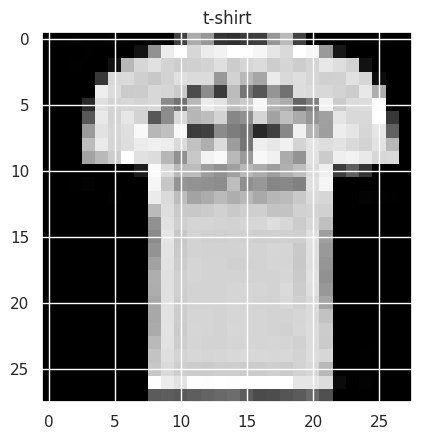

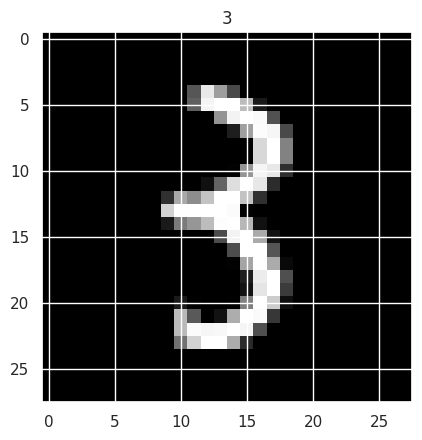

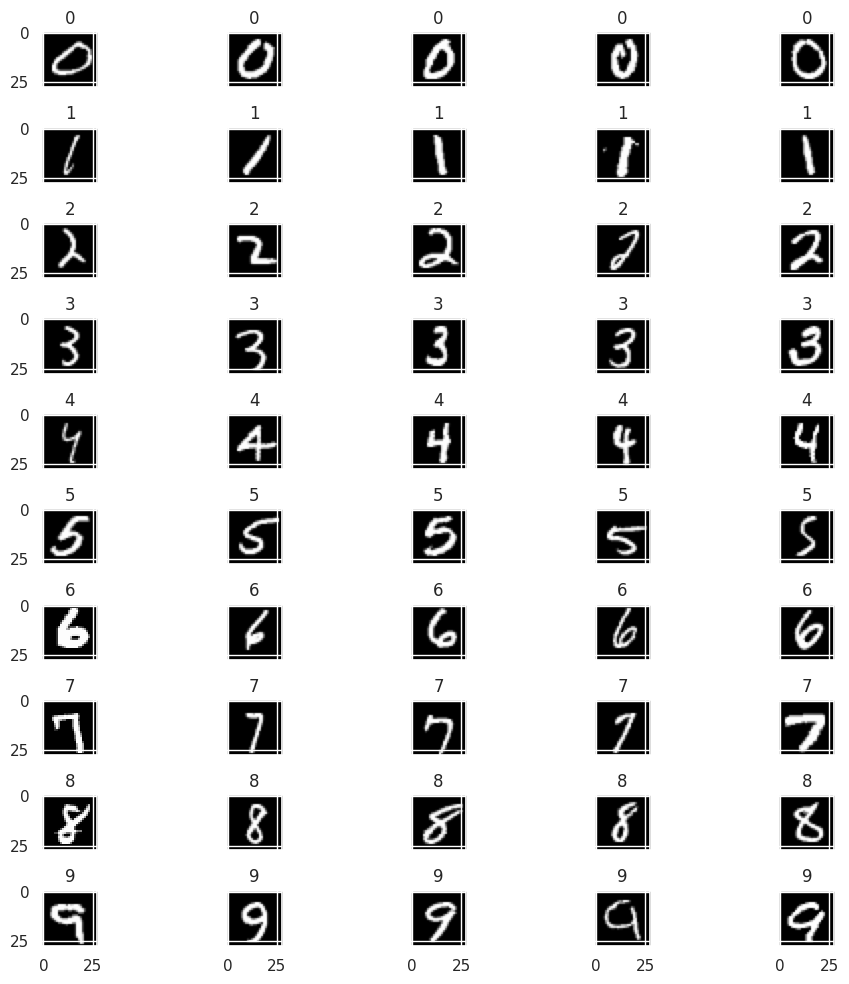

In [5]:
# First training example of X_train_fashion
first_fashion = X_train_fashion[0]
plt.imshow(first_fashion, cmap='gray')
plt.title(label_names[Y_train_fashion[0]])
plt.show()

# First training example of X-train_digits
first_digit = X_train_digits[0]
plt.imshow(first_digit, cmap='gray')
plt.title(Y_train_digits[0])
plt.show()

# Display first 5 imags in X_train_digits for each class
fig, ax = plt.subplots(10,5, sharex=True, sharey=True, figsize=(10,10))

# Loop thru unique digits
for digit in np.unique(Y_train_digits):
    # get the first 5 examples
    class_idx = np.where(Y_train_digits == digit)[0][:5]
    # loop through first 5 examples
    for j in range(len(class_idx)):
        curr_img = X_train_digits[class_idx[j]]
        ax[digit][j].imshow(curr_img, cmap='gray')
        ax[digit][j].set_title(digit)

plt.tight_layout()
plt.show()


### Step 4: Modeling

### <span style="color:chocolate">Exercise 2:</span> Define model (20 points)

1. Fill in the <span style="color:chocolate">build_model()</span> function below, including all the arguments listed in the function definition. Note: the activation function parameter is only for the the hidden layers; use the appropriate final classification function for the final layer.

In [6]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    model = tf.keras.Sequential()
    # create Input latyer
    model.add(tf.keras.Input(shape=(28, 28), name='Input'))

    # flatten layer
    model.add(tf.keras.layers.Flatten(name='Flatten'))

    # add hidden layers
    for h_num, hidden_layer_size in enumerate(hidden_layer_sizes):
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation,
                                        name=f'Hidden_{h_num}'))

    # add output layer
    model.add(tf.keras.layers.Dense(units=n_classes, 
                                    activation='softmax',
                                    name='Output'))

    # set optimizer
    if optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=optimizer,
                  metrics=[metric]
                 )

    return model

---
### Step 5: Experiments

You can now run a suite of experiments to see how the hyperparameters and layer sizes effect model performance. 

The <span style="color:chocolate">train_and_evaluate()</span> function below can be used to run experiments and retrieve results.

Training the digits model...


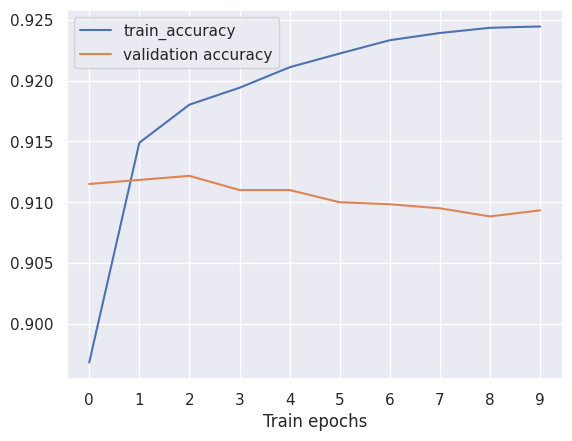

Training accuracy: 0.9244
Validation accuracy: 0.9093


In [7]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    
    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model


# run the function
model = train_and_evaluate()

### <span style="color:chocolate">Exercise 3:</span> Ablation study (50 points)

1. Conduct experiments and record the training and validation set accuracy results in the table below. You may extend the table for additional experiments as needed.
2. Report the hyperparameter values for your preferred architecture configuration.
3. Run the model once more using your preferred hyperparameter configuration.

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | 91.92% | 91.72%
 digits | [] | relu | SGD |0.01| 7850 | 91.95% | 91.53%
 digits | [] | relu | Adam |0.01| 7850 | 92.89%| 90.43%
 digits | [128] | relu | Adam |0.01| 101770 | 99.43% | 97.37%
 digits | [256, 128] | relu | Adam |0.01| 235146 | 98.98% | 97.33%
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | 85.93% | 84.17%
 fashion | [] | relu | SGD |0.01| 7850 | 85.92% | 84.13%
 fashion | [] | relu | Adam |0.01| 7850 | 86.06% | 82.15%
 fashion | [128] | relu | Adam |0.01| 101770 | 90.38% | 84.90%
 fashion | [256, 128] | relu | Adam |0.01| 235146 | 90.81% | 86.00%

Training the digits model...


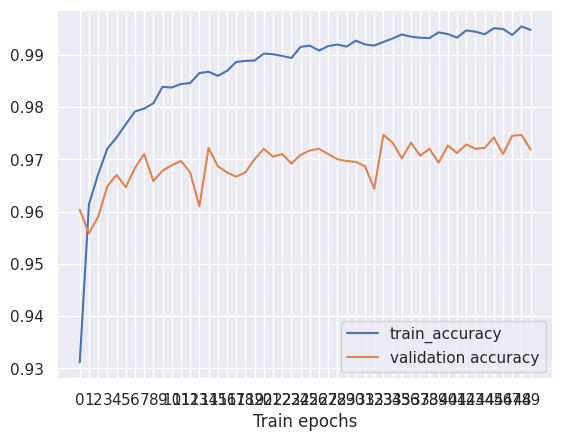

Training accuracy: 0.9947
Validation accuracy: 0.9718


In [8]:
# Preferred parameters for Digits model
# model = train_and_evaluate(data='digits',
#                    hidden_layer_sizes=[128],
#                    activation='relu',
#                    optimizer='Adam',
#                    learning_rate=0.01,
#                    metric='accuracy',
#                    num_epochs=50)

# # Preferred parameters for Fashion model
model = train_and_evaluate(data='digits',
                   hidden_layer_sizes=[128],
                   activation='relu',
                   optimizer='Adam',
                   learning_rate=0.01,
                   metric='accuracy',
                   num_epochs=50)


---
### Step 6: Evaluation and Generalization

### <span style="color:chocolate">Exercise 4:</span> Compute metrics (25 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras and the <span style="color:chocolate">np.max()</span> method available in NumPy; or you can use the <span style="color:chocolate">model.evaluare()</span> method provided by tf.keras directly.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your accuracy observations.

In [9]:
# Evaluate model for Training
Y_train_pred = model.predict(x=X_train_fashion)

# set predicted label based on highest probability
Y_train_maxpred =  np.argmax(Y_train_pred, axis=1)

print('Train, misclassified examples: %d' % (Y_train_fashion != Y_train_maxpred).sum())
error_train_tf = (Y_train_fashion != Y_train_maxpred).sum()/len(Y_train_maxpred)
print('Train, prediction accuracy: %.3f'% (1-error_train_tf))

print('-'*50)

# Evaluate model for Test
Y_test_pred = model.predict(x=X_test_fashion)

# set predicted label based on highest probability
Y_test_maxpred =  np.argmax(Y_test_pred, axis=1)

print('Test, misclassified examples: %d' % (Y_test_fashion != Y_test_maxpred).sum())
error_test_tf = (Y_test_fashion != Y_test_maxpred).sum()/len(Y_test_maxpred)
print('Fashion test, prediction accuracy: %.3f'% (1-error_test_tf))

print('-'*50)
print("""
For digits:
Train accuracy = 99.3%
Test accuracy = 97.3%

For fashion
Train accuracy = 99.2%
Test accuracy = 97.0%

The model for digits and fashion both have strong generalization capabilities with 
accuracy on bots Test data sets being above 97%. The accuracy for the Training sets
are both above 99%, which indicates slight overfitting, however 97% is a very high
score.
""")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Train, misclassified examples: 57352
Train, prediction accuracy: 0.044
--------------------------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test, misclassified examples: 9578
Fashion test, prediction accuracy: 0.042
--------------------------------------------------

For digits:
Train accuracy = 99.3%
Test accuracy = 97.3%

For fashion
Train accuracy = 99.2%
Test accuracy = 97.0%

The model for digits and fashion both have strong generalization capabilities with 
accuracy on bots Test data sets being above 97%. The accuracy for the Training sets
are both above 99%, which indicates slight overfitting, however 97% is a very high
score.

